In [3]:
# imports
import numpy as np
import keras
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt
import json
import coremltools
import cv2 # NOTE: for this to work, install 'opencv' in your environment!

In [4]:
# initialize stuffs

# it's easier to feed the correct item stats like this
class ItemStats:
    def __init__(self, clothDataIndex, numberOfItems, validationSetSize, nameOfMlModel):
        self.cdIndex = clothDataIndex
        self.numOfItems = numberOfItems
        self.valSetSize = validationSetSize
        self.modelName = nameOfMlModel
        
shirts = ItemStats('0', 1996, 400, 'shirt_model')
coats = ItemStats('1', 2000, 400, 'coats_model')
pants = ItemStats('2', 1996, 400, 'pants_model')
shoes = ItemStats('3', 1999, 400, 'shoes_model')
hats = ItemStats('4', 839, 200, 'hats_model')
gloves = ItemStats('5', 175, 50, 'gloves_model')

chosenItem = shirts # only this needs to be changed now in the whole file, to obtain a new model

# I would sure like to auto-switch this based on user, but for now you'll just have to change the folder yourself
rawData = json.load(open('/Users/iosdev/Desktop/backend/ClothesPin/src/data-store/data.json'))

# indices: 0 = shirts; 1 = coats; 2 = pants; 3 = shoes; 4 = hats; 5 = gloves
# (the order comes from the 'searches' array in fetch.js)
clothData = rawData[chosenItem.cdIndex]
clothImageItems = clothData['images']

listOfImageUrls = []
listOfPrices = []
listOfActualImages = []

numOfItems = chosenItem.numOfItems # amount of dl'ded images

In [5]:
# reformat data to work on it more easily

for index in range(0, numOfItems):
    listOfImageUrls.append(clothImageItems[str(index)]['url']) # indices are strings in the json object
    
for index in range(0, numOfItems):
    listOfPrices.append(str(clothImageItems[str(index)]['price'])[:6]) # let's truncate the prices a little bit & see what happens

for url in listOfImageUrls:
    
    # read the image from the folder
    img = cv2.imread(url, cv2.IMREAD_COLOR)
    listOfActualImages.append(img)

In [6]:
# reformatting continues (numpy stuffs)

# make numpy array from the image array (needed to use them for ml)
np_images = np.array(listOfActualImages)

# depending on how Python does stuffs under the hood, the order of the images vs. prices could 
# potentially be scrambled up by this point... we'll just have to hope for the best here
np_prices = np.array(listOfPrices)

# the inner arrays contain the rgb-values of the individual images.
# here we convert the values to be between 0-1 (from 0-255)
for innerArray in np_images:
    
    # this check should not be needed... for some reason though, the last element in the 
    # outer array was of 'NoneType' at one point. now that seems not to be the case anymore 
    # (even though I changed nothing...), but I'm leaving this check here just in case.
    # empty elements would f up the whole model, but we'll just have to hope for the best
    # here, due to lack of time...
    if innerArray is not None:
        innerArray = innerArray.astype('float32')
        innerArray /= 255

In [7]:
# separating a training set and test set from the whole set of images/prices:

trainLimit = numOfItems - chosenItem.valSetSize # the latter number is the amount of test images/prices; change as needed
testLimit = numOfItems # for clarity; could just use numOfItems

x_train = np_images[0:trainLimit]
x_test = np_images[trainLimit:testLimit]

y_train = np_prices[0:trainLimit]
y_test = np_prices[trainLimit:testLimit]

In [ ]:
# building the actual ml model & using it:

model = keras.models.Sequential()

model.add(layers.Conv2D(filters=64,
        kernel_size=(6,6),
        strides=1,
        use_bias=True,
        padding='valid',
        input_shape=(140, 140, 3), # initial image shape
        activation='relu'))

model.add(layers.MaxPooling2D(pool_size=(4, 4), strides=4))

model.add(layers.Conv2D(filters=32,
        kernel_size=(4,4),
        strides=1,
        use_bias=True,
        padding='valid',
        activation='relu'))

model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=3))

model.add(layers.Conv2D(filters=32,
        kernel_size=(2,2),
        strides=1,
        use_bias=True,
        padding='valid',
        activation='relu'))

model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(layers.Conv2D(filters=64,
        kernel_size=(2,2),
        strides=1,
        use_bias=True,
        padding='valid',
        activation='relu'))

model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu')) 
model.add(layers.Dense(1, activation='relu'))

model.compile(optimizer='adam', loss='mse', metrics=['acc'])
# optimizer choices: sgd, adam, rmsprop
# default: sgd (very bad results with it)

model.summary()

hist = model.fit(x_train, y_train, epochs=10, batch_size=40, validation_data=(x_test,y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 135, 135, 64)      6976      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        32800     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 32)          4128      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 64)          8256      
__________

In [7]:
# saving the model in a format that is usable by Xcode:

model.save('temp_model.h5') # intermediary format that's needed for some technical reason

# do not change these stuffs...
coreml_thingy = coremltools.converters.keras.convert('temp_model.h5', input_names = ['image'], 
                                                     output_names = ['output'], image_input_names = 'image')
# Set the model metadata
coreml_thingy.author = 'Team ClothesPin'
coreml_thingy.license = 'ClothesPin'
coreml_thingy.short_description = 'Evaluates the prices of the clothes that the user takes picture of.'

modelNamePlusFileEnding = chosenItem.modelName + '.mlmodel'

coreml_thingy.save(modelNamePlusFileEnding)

0 : conv2d_1_input, <keras.engine.topology.InputLayer object at 0x1272c07b8>
1 : conv2d_1, <keras.layers.convolutional.Conv2D object at 0x1272c0780>
2 : conv2d_1__activation__, <keras.layers.core.Activation object at 0x11db49898>
3 : max_pooling2d_1, <keras.layers.pooling.MaxPooling2D object at 0x1272c0c18>
4 : conv2d_2, <keras.layers.convolutional.Conv2D object at 0x1272c9e80>
5 : conv2d_2__activation__, <keras.layers.core.Activation object at 0x11db49828>
6 : max_pooling2d_2, <keras.layers.pooling.MaxPooling2D object at 0x10b9cfb00>
7 : conv2d_3, <keras.layers.convolutional.Conv2D object at 0x10b9e5748>
8 : conv2d_3__activation__, <keras.layers.core.Activation object at 0x1257e7e80>
9 : max_pooling2d_3, <keras.layers.pooling.MaxPooling2D object at 0x10b9f7a58>
10 : conv2d_4, <keras.layers.convolutional.Conv2D object at 0x11da4c6a0>
11 : conv2d_4__activation__, <keras.layers.core.Activation object at 0x125916860>
12 : max_pooling2d_4, <keras.layers.pooling.MaxPooling2D object at 0x11d

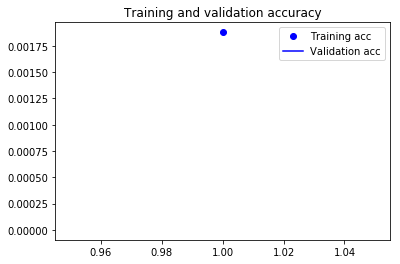

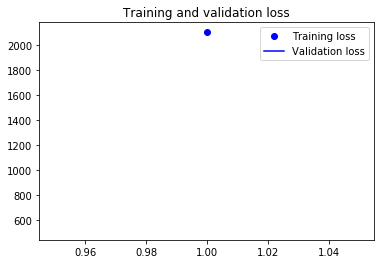

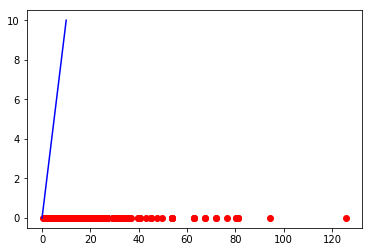

In [8]:
# visualizing the model / training (WIP):

acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

preds = model.predict(x_test)

# print(model.predict(digitimage.reshape(-1, 28*28)))

# print(np.sum(np.round(preds[:,0]) == y_test) / len(y_test))

plt.plot(y_test, preds, 'ro')
plt.plot([0,10], [0,10], 'b')


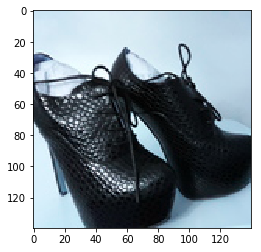

In [9]:
# print example image, to see that it all works:
image1 = np_images[0]

plt.imshow(image1, cmap = plt.cm.binary)
plt.show()

# keeping these as I may try to use them (we never do the reshape thing, which might have adverse effects)
# x_train = x_train.reshape(-1, 28 * 28).astype('float32') / 255.0
# x_test = x_test.reshape(-1, 28 * 28).astype('float32') / 255.0